In [209]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error, log_loss
pd.options.display.precision = 15
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
import time
import datetime
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import json
%matplotlib inline

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [210]:
out_path = './output/'
train_path = './data/train_fea_gen.csv'
test_path = './data/test_A_fea_gen.csv'

In [211]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)


In [212]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds=None, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    splits = folds.split(X) if splits is None else splits
    n_splits = folds.n_splits if splits is None else n_folds
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(splits):
        if verbose:
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12))
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function='Logloss')
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12))
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
            plt.title('LGB Features (avg over folds)')
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict


In [213]:
cat_cols = ['MON_12_CUST_CNT_PTY_ID','AI_STAR_SCO','WTHR_OPN_ONL_ICO',
'SHH_BCK','LGP_HLD_CARD_LVL','NB_CTC_HLD_IDV_AIO_CARD_SITU'] #'COR_KEY_PROD_HLD_NBR',
question_cols = ['REG_CPT','CUR_YEAR_MID_BUS_INC']
large_cale_cols = ['ICO_CUR_MON_ACM_TRX_AMT',
'COUNTER_CUR_YEAR_CNT_AMT',
'PUB_TO_PRV_TRX_AMT_CUR_YEAR',
'MON_12_EXT_SAM_TRSF_IN_AMT',
'MON_12_EXT_SAM_TRSF_OUT_AMT',
'MON_12_EXT_SAM_AMT',
'CUR_MON_EXT_SAM_CUST_TRSF_IN_AMT',
'CUR_MON_EXT_SAM_CUST_TRSF_OUT_AMT',
'LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL',
'CUR_MON_VAL_VLD_CUST_NED_HLD_YEAR_DAY_AVG',
'LAST_12_MON_COR_DPS_DAY_AVG_BAL',
'LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV',
'LAST_12_MON_MON_AVG_TRX_AMT_NAV'
]
continue_cols = []
for col in train.columns:
    if col not in ['CUST_UID','LABEL']+cat_cols+question_cols+large_cale_cols:
        continue_cols.append(col)

for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

# single_onehot = ['MON_12_CUST_CNT_PTY_ID','AI_STAR_SCO','WTHR_OPN_ONL_ICO',
# 'SHH_BCK','LGP_HLD_CARD_LVL','NB_CTC_HLD_IDV_AIO_CARD_SITU']
# for col in single_onehot:
#     try:
#         print("%s_one_hot"%col)
#         train[col + 'one_hot'] = OneHotEncoder().fit_transform(train[col].values.reshape(-1, 1))
#         test[col + 'one_hot'] = OneHotEncoder().fit_transform(train[col].values.reshape(-1, 1))
#     except:
#         print("%s is not valid!"%col)

# train.head()


In [214]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
n_fold = 5
#folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

Mem. usage decreased to 102.54 Mb (0.9% reduction)
Mem. usage decreased to 30.75 Mb (0.7% reduction)


In [215]:
#continue_cols+ ['CUST_UID','LABEL']+cat_cols+question_cols+large_cale_cols
X = train.sort_values('CUST_UID').drop(['LABEL', 'CUST_UID'], axis=1)
y = train.sort_values('CUST_UID')['LABEL']
X_test = test.drop(['CUST_UID'], axis=1)

def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )


print(len(X.columns))
print(X.shape)

330
(40000, 330)


Fold 1 started at Sun May  1 17:44:52 2022
Fold 2 started at Sun May  1 17:46:50 2022
Fold 3 started at Sun May  1 17:49:10 2022
Fold 4 started at Sun May  1 17:51:39 2022
Fold 5 started at Sun May  1 17:53:53 2022
CV mean score: 0.9510, std: 0.0022.


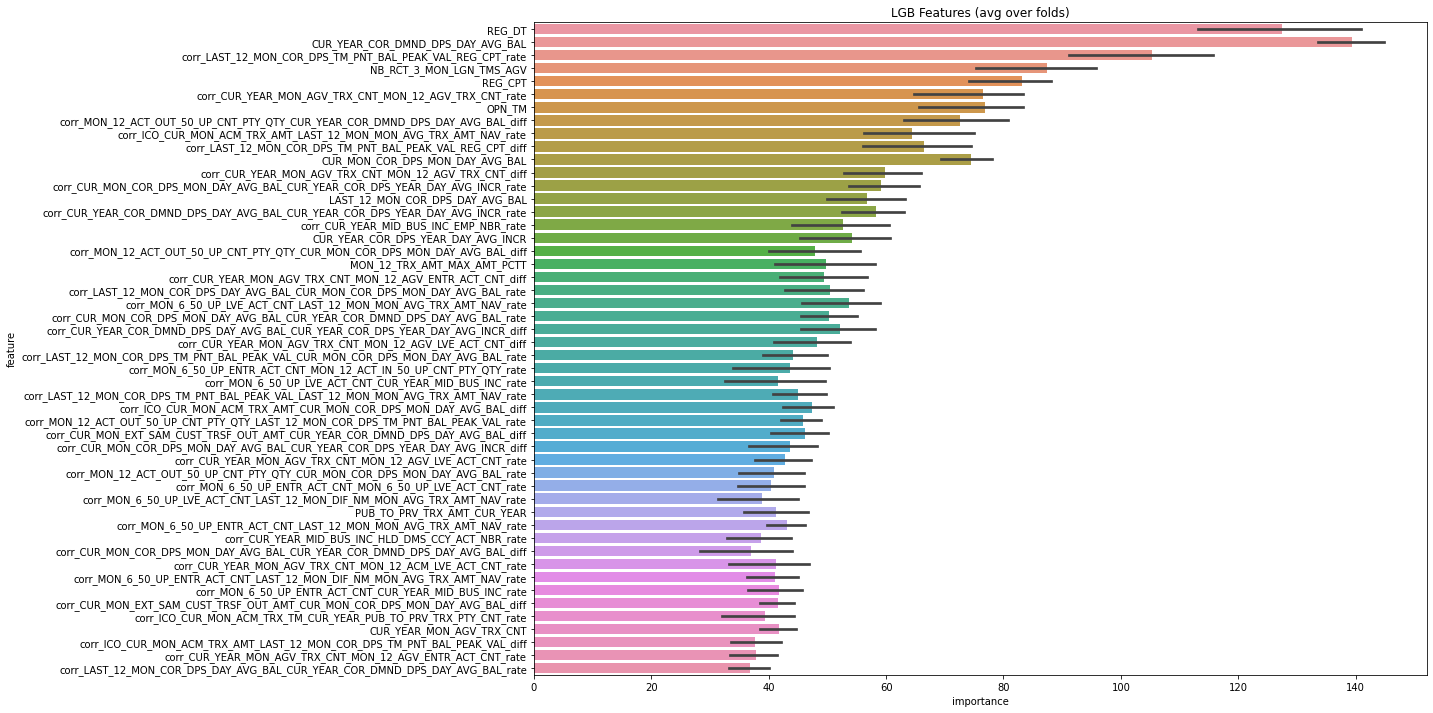

In [216]:
averag = 'rank'#'usual'
model_name = 'lgb'
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9#,
          #'categorical_feature': cat_cols
         }

result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging=averag, n_jobs=-1)

In [217]:
test["LABEL"] = result_dict_lgb['prediction']
columns = ["CUST_UID","LABEL"]
results = test[columns]
results.head()

,CUST_UID,LABEL
0,deca9c4409e84344bc4059116902ba0e,4527.000000000000000
1,25377f79cf9d4964a2f9893dc572caba,11488.600000000000364
2,66979a1614fb49f1bcdcdce75d6abefc,4517.399999999999636
3,84142dedb7e0442eb9aa7aeadf93f66e,1562.799999999999955
4,5e5817f15c8d4bdebefa820961854ac2,2001.799999999999955


In [218]:
scores = result_dict_lgb['scores']
#'CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores))
#results.to_csv(out_path+model_name+"_fload_"+str(n_fold)+"CV_mean_score{0:.4f}std: {1:.4f}.csv".format(np.mean(scores), np.std(scores)),index=None)
results.to_csv(out_path+model_name+"_fload_"+str(n_fold)+'_CV_'+averag+'_score{0:.4f}.txt'.format(np.mean(scores)),sep=' ',index=0,header=0)

In [219]:
averag = 'rank'
model_name = 'xgb'
xgb_params = {'eta': 0.03,
              'max_depth': 11,#5
              'subsample': 0.85,
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'silent': True,
              'nthread': -1,
              'tree_method': 'gpu_hist'}
result_dict_xgb = train_model_classification(X=X, X_test=X_test, y=y, params=xgb_params, folds=folds, model_type=model_name, eval_metric='auc', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging=averag)

Fold 1 started at Sun May  1 17:56:18 2022
[17:56:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.95753	valid_data-auc:0.92905
[500]	train-auc:0.99999	valid_data-auc:0.95155
[509]	train-auc:0.99999	valid_data-auc:0.95161
Fold 2 started at Sun May  1 17:57:09 2022
[17:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly he

In [220]:
test["LABEL"] = result_dict_xgb['prediction']
columns = ["CUST_UID","LABEL"]
results = test[columns]
print(results.head())

model_name = 'xgb2'
scores = result_dict_xgb['scores']
#'CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores))
#results.to_csv(out_path+model_name+"_fload_"+str(n_fold)+"CV_mean_score{0:.4f}.csv".format(np.mean(scores)),index=None)
results.to_csv(out_path+model_name+"_fload_"+str(n_fold)+'_CV_'+averag+'_score{0:.4f}.txt'.format(np.mean(scores)),sep=' ',index=0,header=0)

                           CUST_UID                  LABEL
0  deca9c4409e84344bc4059116902ba0e   4011.000000000000000
1  25377f79cf9d4964a2f9893dc572caba  11570.000000000000000
2  66979a1614fb49f1bcdcdce75d6abefc   4830.600000000000364
3  84142dedb7e0442eb9aa7aeadf93f66e   1699.400000000000091
4  5e5817f15c8d4bdebefa820961854ac2   1849.599999999999909


In [169]:
cols = result_dict_lgb['top_columns'] 
print(cols)

Index(['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL', 'CUR_MON_COR_DPS_MON_DAY_AVG_BAL',
       'REG_DT', 'CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate', 'REG_CPT',
       'CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR', 'NB_RCT_3_MON_LGN_TMS_AGV',
       'CUR_YEAR_MID_BUS_INC', 'LAST_12_MON_COR_DPS_DAY_AVG_BAL', 'OPN_TM',
       'ICO_CUR_MON_ACM_TRX_TM_RATE', 'MON_6_50_UP_ACT_CNT_RATE',
       'CUR_YEAR_MON_AGV_TRX_CNT', 'LAST_12_MON_MON_AVG_TRX_AMT_NAV_rate',
       'LAST_12_MON_COR_DPS_DAY_AVG_BAL_rate', 'PUB_TO_PRV_TRX_AMT_CUR_YEAR',
       'LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV', 'ICO_CUR_MON_ACM_TRX_AMT',
       'MON_12_ACT_50_UP_CNT_PTY_QTY_RATE', 'ICO_CUR_MON_ACM_TRX_TM',
       'LAST_12_MON_MON_AVG_TRX_AMT_NAV', 'MON_12_AGV_ACT_CNT_RATE',
       'MON_12_ACM_ACT_CNT_RATE', 'LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL',
       'AGN_AGR_LATEST_AGN_AMT', 'MON_12_ACM_ENTR_ACT_CNT', 'EMP_NBR',
       'MON_12_TRX_AMT_MAX_AMT_PCTT', 'MON_12_ACM_LVE_ACT_CNT',
       'MON_12_AGV_TRX_CNT', 'MON_12_TRX_AMT_MAX_AMT_PCT

In [170]:
#lgb_res = pd.read_csv('./output/lgb5CV_mean_score0.9506.txt',sep=' ')
# lgb_res = pd.read_csv('./output/lgb5CV_mean_score0.9506.txt',sep=' ',header=None)
# xgb_res = pd.read_csv('./output/xgb_fload_5_CV_rank_score0.9508.txt',sep=' ',header=None)

In [171]:
# final = lgb_res
# final[1] = (lgb_res[1] + xgb_res[1])/2
# final.to_csv(out_path+'merge'+"_fload_"+str(n_fold)+'_CV_'+'mean'+'_score.txt',sep=' ',index=0,header=0)

In [221]:
lgb_rank_res = pd.read_csv('./output/lgb_fload_5_CV_rank_score0.9510.txt',sep=' ',header=None)
xgb_rank_res = pd.read_csv('./output/xgb2_fload_5_CV_rank_score0.9509.txt',sep=' ',header=None)

In [222]:
final_rank = lgb_rank_res
final_rank[1] = (lgb_rank_res[1] + xgb_rank_res[1])/2
final_rank.to_csv(out_path+'merge'+"_fload_"+str(n_fold)+'_CV_'+'rank'+'_score.txt',sep=' ',index=0,header=0)

In [223]:

lgb_rank_res[1] = lgb_rank_res[[1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
xgb_rank_res[1] = xgb_rank_res[[1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
final_rank[1] = final_rank[[1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
final_rank.head()

,0,1
0,deca9c4409e84344bc4059116902ba0e,0.355576310478827
1,25377f79cf9d4964a2f9893dc572caba,0.961015026935072
2,66979a1614fb49f1bcdcdce75d6abefc,0.389349388748979
3,84142dedb7e0442eb9aa7aeadf93f66e,0.135600994012575
4,5e5817f15c8d4bdebefa820961854ac2,0.160167781317233


In [224]:
lgb_rank_res.to_csv(out_path+'lgb_rank_score0.9510.txt',sep=' ',index=0,header=0)
xgb_rank_res.to_csv(out_path+'xgb_rank_score0.9509.txt',sep=' ',index=0,header=0)
final_rank.to_csv(out_path+'merge_rank_lgb0.9510xgb0.9509.txt',sep=' ',index=0,header=0)

In [106]:
averag = 'rank'
model_name = 'cat'

# cb_model = CatBoostRegressor(iterations=500,
#                              learning_rate=0.05,
#                              depth=10,
#                              eval_metric='RMSE',
#                              random_seed = 42,
#                              bagging_temperature = 0.2,
#                              od_type='Iter',
#                              metric_period = 50,
#                              od_wait=20)
cat_params ={
    'learning_rate':0.01,
    "od_type":"Iter",
    'od_wait':100,
    "random_seed": 42,
    "depth": 10,
    'use_best_model': True,
    'verbose': 100
    
}                      
# cat_params = {'eta': 0.03,
#               'max_depth': 11,#5
#               'subsample': 0.85,
#               'objective': 'binary:logistic',
#               'eval_metric': 'auc',
#               'silent': True,
#               'nthread': -1,
#               'tree_method': 'gpu_hist'}
result_dict_xgb = train_model_classification(X=X, X_test=X_test, y=y, params=cat_params, folds=folds, model_type=model_name, eval_metric='auc', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging=averag)

Fold 1 started at Sun May  1 10:55:26 2022
Fold 2 started at Sun May  1 10:58:48 2022
Fold 3 started at Sun May  1 11:01:25 2022
Fold 4 started at Sun May  1 11:04:25 2022
Fold 5 started at Sun May  1 11:06:16 2022
CV mean score: 0.8677, std: 0.0020.


In [107]:
test["LABEL"] = result_dict_xgb['prediction']
columns = ["CUST_UID","LABEL"]
results = test[columns]
print(results.head())


scores = result_dict_xgb['scores']
#'CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores))
#results.to_csv(out_path+model_name+"_fload_"+str(n_fold)+"CV_mean_score{0:.4f}.csv".format(np.mean(scores)),index=None)
results.to_csv(out_path+model_name+"_fload_"+str(n_fold)+'_CV_'+averag+'_score{0:.4f}.txt'.format(np.mean(scores)),sep=' ',index=0,header=0)

                           CUST_UID                  LABEL
0  deca9c4409e84344bc4059116902ba0e   4532.100000000000364
1  25377f79cf9d4964a2f9893dc572caba  10532.100000000000364
2  66979a1614fb49f1bcdcdce75d6abefc   4532.100000000000364
3  84142dedb7e0442eb9aa7aeadf93f66e   4532.100000000000364
4  5e5817f15c8d4bdebefa820961854ac2   4532.100000000000364


In [176]:
# cat_rank_res = pd.read_csv('./output/cat_fload_5_CV_rank_score0.8677.txt',sep=' ',header=None)
# cat_rank_res[1] = cat_rank_res[[1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
# cat_rank_res.to_csv(out_path+'cat_rank_0.8677.txt',sep=' ',index=0,header=0)